In [4]:
#%pip install opencv-python
import numpy as np

In [2]:
# %pip install tensorflow
# %pip install tensorflow_hub


In [7]:
import cv2
import os
import pandas as pd

# Load the CSV data
data = pd.read_csv('Crash_Table.csv')

def load_images_from_folder(folder, max_images=2000):
    images = []
    filenames = sorted(os.listdir(folder))  # sort the filenames
    for i, filename in enumerate(filenames):
        if i >= max_images:
            break
        # img = cv2.imread(os.path.join(folder, filename))
        if filename is not None:
            # Extract video name and frame number from filename and remove leading zeros
            vidname, frame = filename.split('_')[1:3]
            vidname = vidname.lstrip('0')
            frame = int(frame.split('.')[0].lstrip('0'))  # split frame string to exclude the extension and convert it to int
            images.append((filename, vidname, frame))
    return images

# Load images
folder = 'CrashBest'
images = load_images_from_folder(folder)

# Create a dictionary with vidname as keys and frame labels as values
vidname_to_frame_labels = {str(row['vidname']): list(row[1:-1]) for _, row in data.iterrows()}

# Generate labels for the images
image_labels = [vidname_to_frame_labels.get(vidname, [0]*50)[frame-1] for _, vidname, frame in images]

# Convert list of tuples to list of images
images = [img for img, _, _ in images]



In [8]:
# Check the image_label value counts
pd.Series(image_labels).value_counts()

0    1497
1     503
Name: count, dtype: int64

In [9]:
images[:10]

['C_000001_01.jpg',
 'C_000001_02.jpg',
 'C_000001_03.jpg',
 'C_000001_04.jpg',
 'C_000001_05.jpg',
 'C_000001_06.jpg',
 'C_000001_07.jpg',
 'C_000001_08.jpg',
 'C_000001_09.jpg',
 'C_000001_10.jpg']

In [10]:
images[34], image_labels[34]

('C_000001_35.jpg', 1)

In [11]:
# Convert labels to numpy arrays
labels = np.array(image_labels)

In [12]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
if len(labels) == len(images):
    print('Number of labels matches number of images!')
else:
    print('Number of labels does not match number of images!')

Number of labels matches number of images!


In [14]:
unique_labels = np.unique(labels)
unique_labels

array([0, 1])

In [51]:
boolean_labels = [label == unique_labels for label in labels]

In [16]:
images[:10]

['C_000001_01.jpg',
 'C_000001_02.jpg',
 'C_000001_03.jpg',
 'C_000001_04.jpg',
 'C_000001_05.jpg',
 'C_000001_06.jpg',
 'C_000001_07.jpg',
 'C_000001_08.jpg',
 'C_000001_09.jpg',
 'C_000001_10.jpg']

In [17]:
x = images
y = boolean_labels

In [18]:
#%pip install -U scikit-learn


In [19]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x,y,test_size=0.2,random_state=42
)

len(x_train), len(y_train), len(x_val), len(y_val)

(1600, 1600, 400, 400)

In [20]:
import tensorflow as tf
IMG_SIZE = 224

def process_image(image_path):
    # Read an image file
    image = tf.io.read_file(image_path)
    # Turning jpeg inamge into number tensor with 3 colour (Red,Green,Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image,tf.float32)
    # Resize the image 
    image  = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    
    return image

In [21]:
def get_image_label(image_path, label): # Add the folder path to the image filename
    image_path = tf.strings.join(['CrashBest', image_path], separator='/')
    image = process_image(image_path)
    return image, label

In [22]:
get_image_label(x[0], y[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], 

In [23]:
BATCH_SIZE = 32

def create_data_batches(x,y=None,batch_size=BATCH_SIZE, valid_data=False,test_data=False):
    if test_data:
        print('Creating test data batches')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    elif valid_data:
        print('Creating validation data batches')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y))) # Filepaths
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
                        
    else:
        print('Creating train data batches')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y))) # Filepaths
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

In [24]:
train_data = create_data_batches(x_train,y_train)
val_data = create_data_batches(x_val,y_val,valid_data=True)

Creating train data batches
Creating validation data batches


In [25]:
#%pip install matplotlib


In [26]:
# Defining how our input will look like
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE,3] # batch,height,width,colour channels

# Setup output shape of model
OUTPUT_SHAPE = len(image_labels)

# Model Url
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'


In [27]:
import tensorflow_hub as hub

In [28]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print('Building model...')
    # Setup the model
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),# Layer 1(input layer)
        tf.keras.layers.Dense(units=2,# Layer 2(output layer)
                             activation='softmax')
    ])
    # Compile the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    model.build(INPUT_SHAPE)
    
    return model

In [29]:
model = create_model()
model.summary()

Building model...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 5434717 (20.73 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [30]:
# Tracking model progress using tensorboard
%load_ext tensorboard

In [31]:
import datetime

def create_tensorboard_callback():
    # Making a log directory
    logdir = os.path.join('logs',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                         )
    return tf.keras.callbacks.TensorBoard(logdir)

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=3)

In [33]:
NUM_EPOCHS = 100

In [34]:
def train_model():
    model = create_model()
    tensorboard = create_tensorboard_callback()
    # Fit the model
    model.fit(x=train_data,
          epochs=NUM_EPOCHS,
          validation_data=val_data,  # add this line
          callbacks=[tensorboard, early_stopping])

    return model

In [35]:
model = train_model()

Building model...


Epoch 1/100
50/50 [==============================] - 19s 348ms/step - loss: 0.5375 - accuracy: 0.7656 - val_loss: 0.3708 - val_accuracy: 0.8225
Epoch 2/100
50/50 [==============================] - 18s 354ms/step - loss: 0.2867 - accuracy: 0.8775 - val_loss: 0.3142 - val_accuracy: 0.8675
Epoch 3/100
50/50 [==============================] - 19s 371ms/step - loss: 0.2167 - accuracy: 0.9125 - val_loss: 0.2632 - val_accuracy: 0.9075
Epoch 4/100
50/50 [==============================] - 21s 420ms/step - loss: 0.1852 - accuracy: 0.9300 - val_loss: 0.2548 - val_accuracy: 0.8950
Epoch 5/100
50/50 [==============================] - 21s 421ms/step - loss: 0.1728 - accuracy: 0.9337 - val_loss: 0.2345 - val_accuracy: 0.9175
Epoch 6/100
50/50 [==============================] - 20s 405ms/step - loss: 0.1577 - accuracy: 0.9344 - val_loss: 0.2112 - val_accuracy: 0.9250
Epoch 7/100
50/50 [==============================] - 21s 422ms/step - loss: 0.1434 - accuracy: 0.9444 - val_loss: 0.2113 - val_accuracy:

In [36]:
def save_model(model,suffix=None):
    modeldir = os.path.join('Model',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
    model_path = modeldir + '-' + suffix + '.h5'
    print('Saving model')
    model.save(model_path)
    return model_path


In [37]:
save_model(model,suffix='NewModel-1.0.1')

Saving model


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'Model/20230710-16231688986437-NewModel-1.0.1.h5'

In [38]:
# Visualize the result
#%tensorboard --logdir logs

In [39]:
predictions = model.predict(val_data, verbose=1)

13/13 [==============================] - 4s 285ms/step


In [40]:
predictions.shape

(400, 2)

In [41]:
index=4
print(f"Max Value: {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_labels[np.argmax(predictions[index])]}")

Max Value: 0.8975700736045837
Sum: 1.0
Max index: 0
Predicted label: 0


In [42]:
def get_pred_label(prediction_probabilities):
    return unique_labels[np.argmax(prediction_probabilities)]

pred_label =  get_pred_label(predictions[7])
pred_label


0

In [43]:
def unbatchify(data):
    '''
    unbatch data and return seperate arrays of images and labels
    '''
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_labels[np.argmax(label)])
        
    return images, labels

val_images , val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.15967388, 0.22241898, 0.31261507],
         [0.21736696, 0.28011206, 0.37030813],
         [0.21736696, 0.28011206, 0.37030813],
         ...,
         [0.6042025 , 0.7263303 , 0.9610653 ],
         [0.60546213, 0.7303923 , 0.95554215],
         [0.5313908 , 0.63895243, 0.8669826 ]],
 
        [[0.2182073 , 0.2809524 , 0.37114847],
         [0.27955183, 0.34229693, 0.43249303],
         [0.27955183, 0.34229693, 0.43249303],
         ...,
         [0.64146733, 0.76386535, 0.9966489 ],
         [0.6396858 , 0.76461595, 0.9962685 ],
         [0.5640029 , 0.67111444, 0.91543096]],
 
        [[0.2334734 , 0.2962185 , 0.3864146 ],
         [0.31554624, 0.37829137, 0.46848744],
         [0.31554624, 0.37829137, 0.46848744],
         ...,
         [0.65840393, 0.78445333, 0.9978992 ],
         [0.6589735 , 0.78613454, 0.9980492 ],
         [0.5904927 , 0.6980544 , 0.9372691 ]],
 
        ...,
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.     

In [44]:
print(f"Length of predictions: {len(predictions)}")
print(f"Length of val_labels: {len(val_labels)}")
print(f"Length of val_images: {len(val_images)}")

Length of predictions: 400
Length of val_labels: 400
Length of val_images: 400


In [45]:
import matplotlib.pyplot as plt
# Visualizing prediction
def plt_pred(prediction_probablities, labels, images,n=1):
    pred_prob, true_label, image = prediction_probablities[n],labels[n],images[n]
    # Gat the pred label
    pred_label = get_pred_label(pred_prob)
    # Plot images
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if pred_label ==true_label:
        color = 'green'
    else:
        color = 'red'
    plt.title('{}{:2.0f}% {}'.format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label),
                                    color=color)


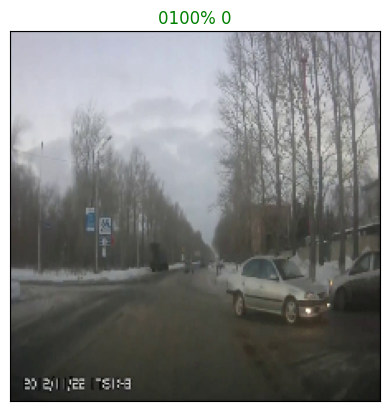

In [46]:
plt_pred(prediction_probablities=predictions,
        labels=val_labels,
        images=val_images,
        n=3)

In [47]:
def plot_pred_conf(prediction_porbablities, labels,n=1):
    pred_prob, true_label = prediction_porbablities[n], labels[n]
    # Predicted label
    pred_label= get_pred_label(pred_prob)
    # Top10
    top_10 = pred_prob.argsort()[-10:][::-1]
    top_10_values = pred_prob[top_10]
    top_10_labels = unique_labels[top_10]
    
    # PLot it in graph
    top_plot = plt.bar(np.arange(len(top_10_labels)),
                      top_10_values,
                      color='grey')
    plt.xticks(np.arange(len(top_10_labels)),
              labels = top_10_labels,
              rotation='vertical')
    # To see which label is correct
    if np.isin(true_label,top_10_labels):
        top_plot[np.argmax(top_10_labels == true_label)].set_color('green')
    else:
        pass

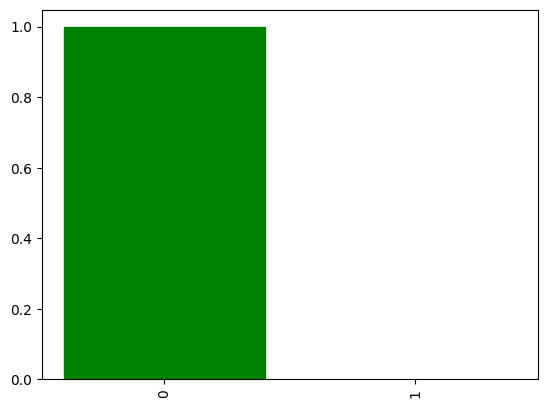

In [48]:
plot_pred_conf(prediction_porbablities=predictions,
              labels = val_labels,
              n=9)


/var/folders/6d/_4vw0mys0gdbmrdsmb416gbc0000gn/T/ipykernel_14609/779929746.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=1.0)


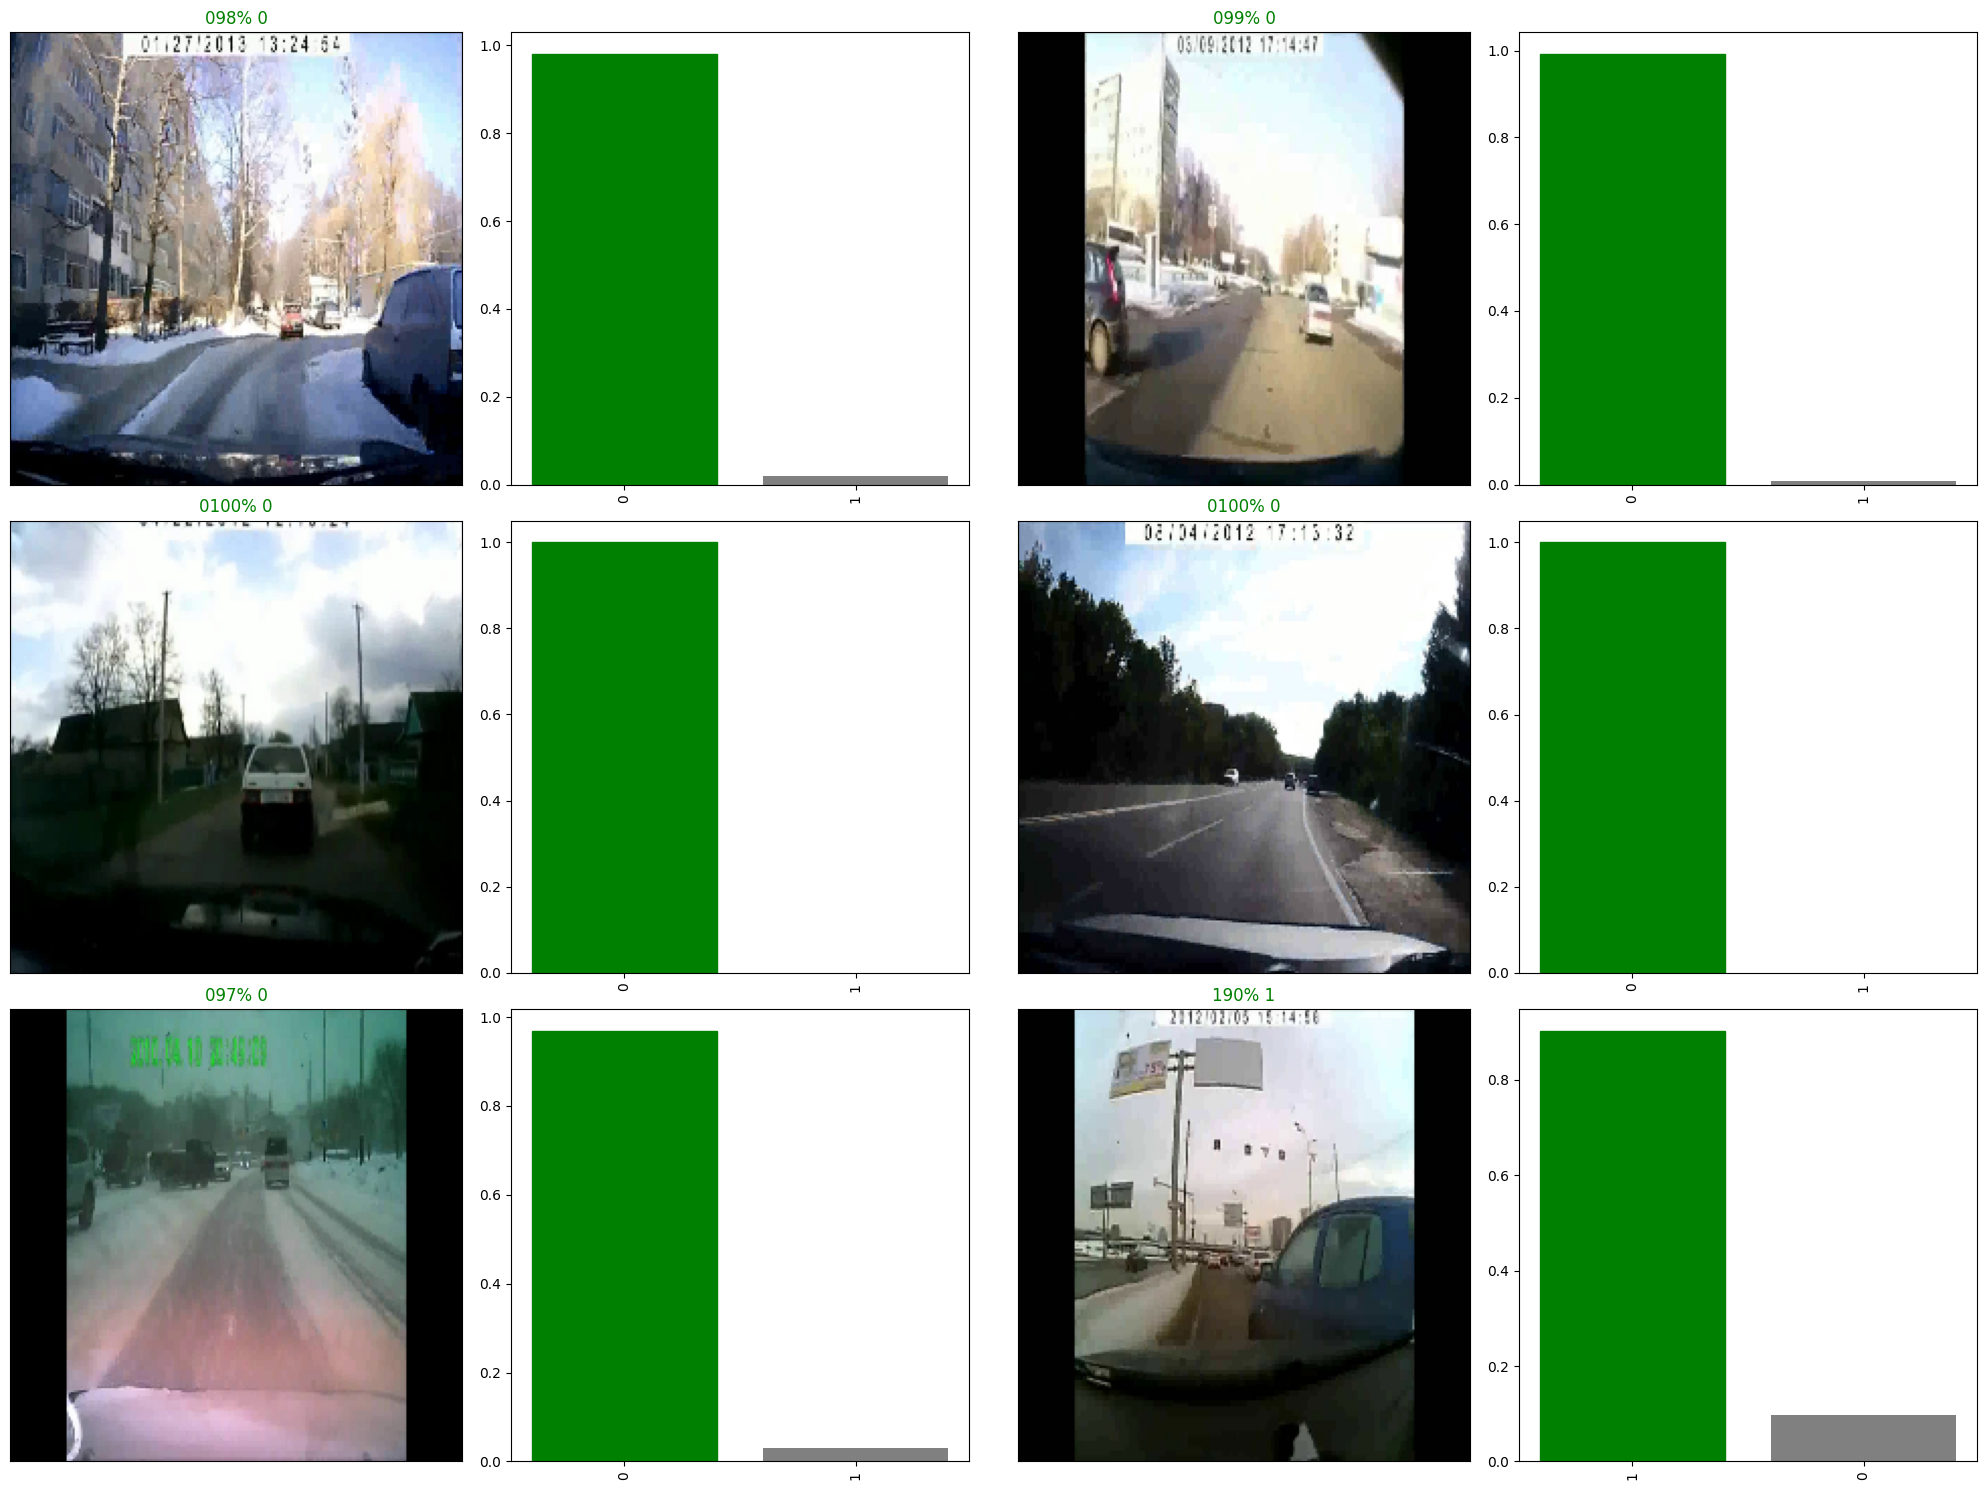

In [50]:
i_multiplier = 200
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows,2*num_cols ,2*i+1)
    plt_pred(prediction_probablities= predictions,
             labels = val_labels,
             images = val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols,2*i+2)
    plot_pred_conf(prediction_porbablities=predictions,
                  labels=val_labels,
                  n=i+i_multiplier)
    plt.tight_layout(h_pad=1.0)
plt.show()

In [3]:
import tensorflow as tf

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates